In [1]:
import numpy as np
from sklearn import datasets
from sklearn import preprocessing
from scipy.cluster.vq import whiten
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit
from qiskit import Aer, execute
from numpy import pi
from copy import deepcopy
from numpy import pi
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit
from qiskit import Aer, execute
import sys
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
def _encode_feature(x):
    return ((x + 1) * pi / 2)

def distance_centroids(point, centroids, backend=None, shots=1024):
    k = len(centroids)
    phi_list = [_encode_feature(point[0])]
    theta_list = [_encode_feature(point[1])]
    for i in range(k):
        phi_list.append(_encode_feature(centroids[i][0]))
        theta_list.append(_encode_feature(centroids[i][1]))
    qreg = QuantumRegister(k, 'qreg')
    creg = ClassicalRegister(1, 'creg')
    qc = QuantumCircuit(qreg, creg, name='qc')
    if not backend:
        backend = Aer.get_backend('qasm_simulator')
    results_list = []
    for i in range(1, k + 1):
        qc.h(qreg[2])
        qc.u3(theta_list[0], phi_list[0], 0, qreg[0])           
        qc.u3(theta_list[i], phi_list[i], 0, qreg[1])
        qc.cswap(qreg[2], qreg[0], qreg[1])
        qc.h(qreg[2])
        qc.measure(qreg[2], creg[0])
        qc.reset(qreg)
        job = execute(qc, backend=backend, shots=shots)
        result = job.result().get_counts(qc)
        try:
            results_list.append(result['1'])
        except:
            results_list.append(0)
    return results_list

In [3]:
def generate_dataset(k=3, num_point_class=45):
    n = k * num_point_class
    
    true_centroids_x = [-0.4, 0.6, 0.0]
    true_centroids_y = [-0.4, 0.0, 0.8]
    true_centroids_var_x = [0.25, 0.2, 0.1]
    true_centroids_var_y = [0.25, 0.2, 0.6]

    x = np.random.normal(loc=true_centroids_x[0], scale=true_centroids_var_x[0], size=num_point_class) 
    y = np.random.normal(loc=true_centroids_y[0], scale=true_centroids_var_y[0], size=num_point_class)
    category = np.repeat(0, num_point_class)
    
    for i in range(1, k):
        category = np.vstack((category, np.repeat(i, num_point_class)))
        x = np.vstack((x, np.random.normal(loc=true_centroids_x[i], scale=true_centroids_var_x[i], size=num_point_class)))
        y = np.vstack((y, np.random.normal(loc=true_centroids_y[i], scale=true_centroids_var_y[i], size=num_point_class)))

    data = np.vstack([x.reshape(n), y.reshape(n)]).transpose()
    category = category.reshape(n)

    return data, category


def load_dataset(name="random"):
    if name == "random":
        data, category = generate_dataset()
        
    elif name == "iris":
        iris = datasets.load_iris()
        # taking n = 2 features
        data = whiten(iris.data[:, :2])  
        category = iris.target
    return data, category

In [4]:
def point_centroid_distances(point, centroids):
    phi_list = [((x + 1) * pi / 2) for x in [point[0], centroids[0][0], centroids[1][0], centroids[2][0]]]
    theta_list = [((x + 1) * pi / 2) for x in [point[1], centroids[0][1], centroids[1][1], centroids[2][1]]]

    qreg = QuantumRegister(3, 'qreg')
    creg = ClassicalRegister(1, 'creg')
    qc = QuantumCircuit(qreg, creg, name='qc')
    backend = Aer.get_backend('qasm_simulator')

    results_list = []
    for i in range(1, 4):
        qc.h(qreg[2])
        qc.u3(theta_list[0], phi_list[0], 0, qreg[0])           
        qc.u3(theta_list[i], phi_list[i], 0, qreg[1])
        qc.cswap(qreg[2], qreg[0], qreg[1])
        qc.h(qreg[2])
        qc.measure(qreg[2], creg[0])

        qc.reset(qreg)
        job = execute(qc, backend=backend, shots=1024)
        result = job.result().get_counts(qc)
        try:
            results_list.append(result['1'])
        except:
            results_list.append(0)
    return results_list


def qcluster(n_features=2, df=None):
    read_feats = ['Feature ' + str(i) for i in range(1, n_features + 1)]
    read_feats.append("Class")
    colors = df["Class"].unique().tolist()
    colors.reverse()
    k = len(colors)
    df["Class"] = pd.Categorical(df["Class"])
    df["Class"] = df["Class"].cat.codes
    data = df.values[:, 0:n_features]
    category = df.values[:, n_features]
    n = data.shape[0]
    c = data.shape[1]
    mean = np.mean(data, axis = 0)
    std = np.std(data, axis = 0)
    centers = np.random.randn(k,c)*std + mean
    centers = np.array([[-0.25, 0.2], [0, -0.1], [0.25, 0.35]])

    threshold = 2e-2
    error_tolerance = 1e-1

    centers_old = np.zeros(centers.shape) 
    centers_new = deepcopy(centers)  

    clusters = np.zeros(n)
    distances = np.zeros((n, k))

    error = np.linalg.norm(centers_new - centers_old)
    upper_error = np.inf

    while (error - error_tolerance) < upper_error and error > threshold:
        distances = np.array(list(map(lambda x: distance_centroids(x, centers), data)))
        clusters = np.argmin(distances, axis=1)
        centers_old = deepcopy(centers_new)
        for i in range(k):
            centers_new[i] = np.mean(data[clusters == i], axis=0)

        upper_error = deepcopy(error)
        error = np.linalg.norm(centers_new - centers_old)
        print("Error: {}".format(error))
        
    return data,centers_new




In [5]:
data, category = load_dataset(name="random")
n_features = len(data[0])
class_counts = len(np.unique(category))
cols = []
for i in range(n_features):
    cols.append("col"+str(i))
df = pd.DataFrame(data, columns = cols)
df['Class'] = category
dataq,centers_new = qcluster(n_features, df)

/var/folders/34/3xz2_08s3pq8vmdlq5rgvyww0000gn/T/ipykernel_29916/289988394.py:19: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  qc.u3(theta_list[0], phi_list[0], 0, qreg[0])
/var/folders/34/3xz2_08s3pq8vmdlq5rgvyww0000gn/T/ipykernel_29916/289988394.py:20: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  qc.u3(theta_list[i], phi_list[i], 0, qreg[1])
/opt/miniconda3/envs/q

Error: 0.39749564194252046
Error: 0.09753027029814687
Error: 0.04730586233067615
Error: 0.04373472549693457
Error: 0.04578218490851169
Error: 0.05749584613635067
Error: 0.06499378079074586
Error: 0.05116650934636979
Error: 0.07841022810139354
Error: 0.08410923166170427
Error: 0.0995720896225287
Error: 0.05216428910997564
Error: 0.07672680902027221
Error: 0.10471581796364317
Error: 0.07193138960179955
Error: 0.036890746177832855
Error: 0.1185697077415278
Error: 0.161885691640459
Error: 0.07913046746452358
Error: 0.1252941321888377
Error: 0.12362977840235857
Error: 0.07420145626483302
Error: 0.10588074648404852
Error: 0.023574594328686645
Error: 0.03597797701509597
Error: 0.03628973861580399
Error: 0.05631825669620739
Error: 0.07369842547965823
Error: 0.11213903418564457
Error: 0.05188322831730077
Error: 0.04717630364092107
Error: 0.07871968734026996
Error: 0.04946514490161749
Error: 0.10932154776255583
Error: 0.04731347745736874
Error: 0.08862202512506466
Error: 0.1792681316159844
Error

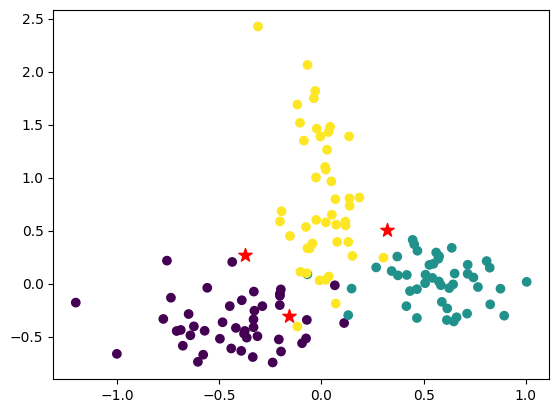

In [6]:
colors = df["Class"].unique().tolist()
colors.reverse()
n = data.shape[0]
plt.scatter(dataq[:, 0], dataq[:, 1], c = category)
plt.scatter(centers_new[:, 0], centers_new[:, 1], marker='*', s = 100, c = 'red')
plt.show()

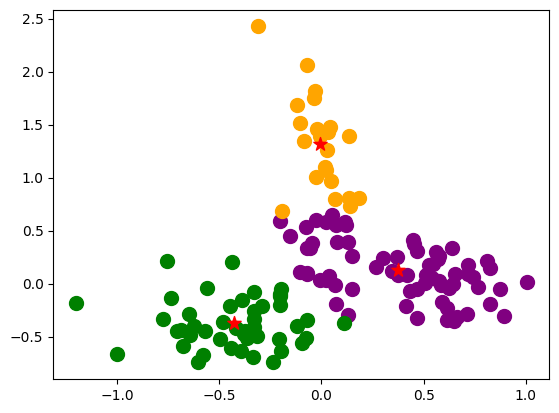

In [7]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(data)
plt.scatter(data[y_kmeans == 0, 0], data[y_kmeans == 0, 1], s = 100, c = 'purple')
plt.scatter(data[y_kmeans == 1, 0], data[y_kmeans == 1, 1], s = 100, c = 'orange')
plt.scatter(data[y_kmeans == 2, 0], data[y_kmeans == 2, 1], s = 100, c = 'green')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'red',  marker='*')